In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import re
import operator
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Read in data and select appropriate data needed.

In [5]:
data = pd.read_csv("tripadvisor_hotel_reviews.csv", encoding="utf-8")

high_data = data.loc[(data['Rating'] == 5) | (data["Rating"] == 4)]
mid_data = data.loc[(data['Rating'] == 3)]
low_data = data.loc[(data['Rating'] == 1) | (data["Rating"] == 2)]

high_reviews = high_data["Review"]
mid_reviews = mid_data["Review"]
low_reviews = low_data["Review"]

# Select 2000 high reviews and 2000 low reviews (limited due to computing power)
#high_reviews = high_reviews[0:3000]
#low_reviews = low_reviews[0:3000]
#combined = pd.concat([high_reviews, low_reviews])

len(high_reviews)

15093

In [11]:
# Process text. It is much easier to process text and a string, and prepare for sentence tokenizing with Word2Vec.
def process_df_series(df_series):
    combined_string = ". ".join(df_series.to_numpy().tolist())
    text1 = re.sub(r"n't", "", combined_string) # removes n't 
    text1 = re.sub(r"\s+[a-zA-Z]\s+", " ", text1) # removes single characters
    text1 = re.sub(r",\s+\s+", "", text1) # removes comma-space-space
    text1 = re.sub(r", ", ". ", text1) # replaces comma-space with full-stop-space
    

    return text1

In [12]:
# These three variables are the 3 processed corpuses
high_text = process_df_series(high_reviews)
low_text = process_df_series(low_reviews)
#combined_text = process_df_series(combined)

Create a word cloud to visualise most frequent words in the high reviews, then the low reviews.

In [13]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show()

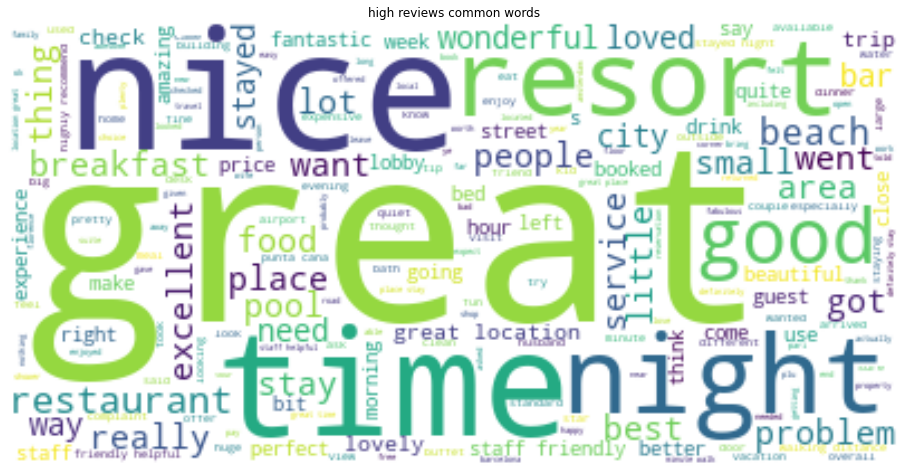

In [15]:
# Remove very common words hotel, room, day, and the one character s for the word cloud
high_text1 = re.sub(r"hotel", "", high_text)
high_text1 = re.sub(r"room", " ", high_text1) 
high_text1 = re.sub(r"day", " ", high_text1) 
high_text1 = re.sub(r"\s+[a-zA-Z]\s+", " ", high_text1)

new_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(high_text1)
show_word_cloud(new_cloud, "high reviews common words")

In [18]:
# Shows frequency of words, and sorts in descending order
freq = WordCloud().process_text(high_text)
sorted_d = dict( sorted(freq.items(), key=operator.itemgetter(1),reverse=True))
#sorted_d

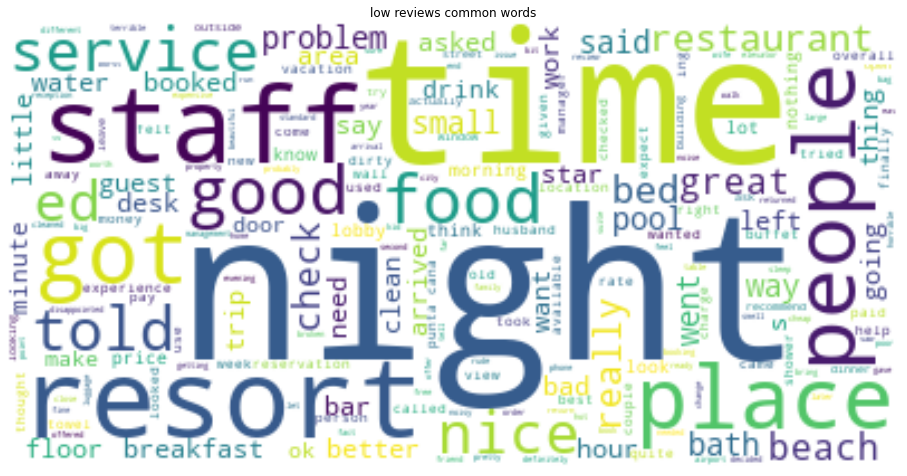

In [16]:
# Remove very common words hotel, room, day, and the one character s for the word cloud
low_text1 = re.sub(r"hotel", "", low_text)
low_text1 = re.sub(r"room", " ", low_text1)
low_text1 = re.sub(r"day", " ", low_text1)
low_text1 = re.sub(r"stay", " ", low_text1) 
low_text1= re.sub(r"\s+[a-zA-Z]\s+", " ", low_text1)

new_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(low_text1)
show_word_cloud(new_cloud, "low reviews common words")

In [20]:
# Shows frequency of words, and sorts in descending order
freq = WordCloud().process_text(low_text1)
sorted_d = dict( sorted(freq.items(), key=operator.itemgetter(1),reverse=True))
#sorted_d

Use Word2Vec to tokenize sentences.

In [33]:
# Tokenize sentences - choose high_text, low_text, or combined_text for analysis
sentences = nltk.sent_tokenize(low_text)
sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
for i in range(len(sentences)):
    sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]

In [34]:
# Print sentence example
sentences[10]

['asked',
 'desk',
 'good',
 'breakfast',
 'spots',
 'neighborhood',
 'hood',
 'told',
 'hotels',
 '.']

In [35]:
# Apply Word2Vec to vectorise sentences and embed words.
model = Word2Vec(sentences, min_count=2, size = 50)
words = model.wv.vocab
X = model[words]
len(words)

12175

In [42]:
# Find similar words - takes parameters word and number of words to display
similar = model.wv.most_similar('woman',topn=20)
similar

[('receptionist', 0.9980896711349487),
 ('nobody', 0.9964079260826111),
 ('reported', 0.9961305260658264),
 ('bell', 0.9957444667816162),
 ('man', 0.9954960942268372),
 ('girl', 0.9953604936599731),
 ('inquired', 0.9952865839004517),
 ('gentleman', 0.9944122433662415),
 ('assistance', 0.9934377074241638),
 ('yelled', 0.9933125972747803),
 ('attendant', 0.9931972026824951),
 ('clerks', 0.9931079745292664),
 ('respond', 0.9929647445678711),
 ('complaining', 0.9927446246147156),
 ('reply', 0.9923564791679382),
 ('response', 0.9921988248825073),
 ('assistant', 0.9921627640724182),
 ('employee', 0.9915286302566528),
 ('talk', 0.9913010001182556),
 ('none', 0.9912170171737671)]

Apply K-Means clustering the the embedded word vectors.

In [37]:
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
import numpy as np

In [38]:
NUM_CLUSTERS = 7
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit_predict(X)
 
labels = kmeans.labels_
centers = kmeans.cluster_centers_

Select the words most similar to the cluster centres and put the words/similarity into a DataFrame.

In [39]:
# Initialisize first cluster words a dataframe
vec = centers[0]
similars = model.wv.most_similar(positive=[vec], topn= 100) # top 100 similar words
df = pd.DataFrame.from_records(similars, columns=['Cluster 1', 'Similarity 1'])

# Loop to concat the original dataframe with each cluster and its words
for i in range(1,NUM_CLUSTERS):
    vec = centers[i]
    similars = model.wv.most_similar(positive=[vec], topn= 100)
    df_current = pd.DataFrame.from_records(similars, columns=['Word '+str(i+1), 'Similarity '+str(i+1)])
    df = pd.concat([df, df_current], axis=1)

df


,Cluster 1,Similarity 1,Word 2,Similarity 2,Word 3,Similarity 3,Word 4,Similarity 4,Word 5,Similarity 5,Word 6,Similarity 6,Word 7,Similarity 7
0,excessive,0.998884,ear,0.999168,getaway,0.993320,shows,0.999086,ear,0.998995,peeling,0.996265,checkout,0.996949
1,various,0.998715,easily,0.998964,inn,0.992676,important,0.998239,loss,0.998871,closet,0.996144,leaving,0.995926
2,horror,0.998610,loss,0.998892,1500,0.991515,tough,0.998005,various,0.998744,leaked,0.996020,arguing,0.995905
3,cut,0.998521,mention,0.998701,holiday,0.991324,negatives,0.997966,excessive,0.998714,tiles,0.995583,noon,0.994093
4,steep,0.998516,activity,0.998678,seattle,0.991286,pros,0.997598,dealer,0.998672,counters,0.995088,message,0.993773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,load,0.996653,decency,0.996771,olympic,0.968888,aside,0.993413,scared,0.996851,dripped,0.982600,statement,0.980770
96,happening,0.996646,commercial,0.996761,rome,0.968769,peace,0.993353,useful,0.996845,adjoining,0.982568,received,0.980730
97,paul,0.996645,wasn__Ç_é_,0.996734,hotwire,0.968660,trendy,0.993268,prevent,0.996844,linen,0.982418,contacted,0.980713
98,landing,0.996636,giving,0.996718,christmas,0.968565,hype,0.993195,comes,0.996843,shaking,0.982414,unexplained,0.980620


In [40]:
df.to_csv("low-clustered-words.csv") # exports dataframe to .csv file